In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import os
from numba import jit, int32
import imageio.v2 as imageio

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [75]:
@jit(nopython=True)
def randomAtRadius(radius, seedX, seedY):
    theta = 2*np.pi*np.random.random()
    x=int32(int(radius*np.cos(theta))+seedX)
    y=int32(int(radius*np.sin(theta))+seedY)
    location= np.array([x, y], dtype=np.int32)
    return location

In [76]:
@jit(nopython=True)
def checkAround(location, squareSize, matrix):
	foundFriend = False #found another particle
	exitCircle = False #reached the required radius
	nearEdge=False #near the edge of the field


    # Check if a walker is near the edge
	if (location[1] + 1) > squareSize - 1 or (location[1] - 1) < 1 or (location[0] + 1) > squareSize - 1 or (location[0] - 1) < 1:
		nearEdge = True

    # If not near the edge, check if the walker is near a neighbor or reached the required radius
    # location[1]=row, location[2]=column
	if not nearEdge:
		neighborDown = matrix[location[1]+1, location[0]]
		if neighborDown == 1:
			foundFriend = True
		if neighborDown == 2:
			exitCircle = True

		neighborUp=matrix[location[1] - 1 , location[0]]
		if neighborUp==1:
			foundFriend=True
		if neighborUp==2:
			exitCircle=True

		neighborRight=matrix[location[1], location[0] + 1]
		if neighborRight==1:
			foundFriend=True
		if neighborRight==2:
			exitCircle=True

		neighborLeft=matrix[location[1], location[0] - 1]
		if neighborLeft==1:
			foundFriend=True
		if neighborLeft==2:
			exitCircle=True

    # After checking locations, if locations are good, start the random walk
	if not foundFriend and not nearEdge:
		decide = np.random.random()
		if decide<0.25:
			location = np.array([location[0] - 1,location[1]], dtype=np.int32)
		elif decide<0.5:
			location = np.array([location[0] + 1,location[1]], dtype=np.int32)
		elif decide<0.75:
			location = np.array([location[0],location[1] + 1], dtype=np.int32)
		else:
			location = np.array([location[0],location[1] - 1], dtype=np.int32)

	return (location, foundFriend, nearEdge, exitCircle)

In [77]:
def save_image(matrix, addedCount):
    cmap = colors.ListedColormap(['teal','azure', 'teal'])
    label = str(addedCount)
    plt.matshow(matrix, fignum=None, interpolation='nearest', cmap=cmap)
    plt.savefig("/content/gdrive/MyDrive/5SEM/SIM/images/cluster{}.png".format(label), dpi=200)
    plt.close()

In [78]:
@jit(nopython=True)
def initialize_matrix(radius):
    seedX = radius + 2
    seedY = radius + 2
    squareSize = radius * 2 + 5

    matrix = np.zeros((squareSize, squareSize), dtype=np.int32)

    for row in range(squareSize):
        for col in range(squareSize):
            # Put a seed particle
            if row == seedY and col == seedX:
                matrix[row, col] = 1
            # Define field outside of the circle
            elif (seedX - col) ** 2 + (seedY - row) ** 2 > radius ** 2:
                matrix[row, col] = 2

    return seedX, seedY, squareSize, matrix

In [84]:
def DLAcluster(radius, needGif):

    seedX, seedY, squareSize, matrix = initialize_matrix(radius)

    # Initialize the random walker counter
    randomWalkersCount = 0
    random.seed()
    # Set the cluster to NOT be complete
    completeCluster = False

    #keep track of number added
    addedCount=0

    # initialize array for the used interval for graphing
    usedInterval= []

    while not completeCluster:
        # Release a walker
        randomWalkersCount += 1

        # Generate a (Xstart, Ystart) for walker, need within radius
        location=randomAtRadius(radius, seedX, seedY)

        # Initialize variables, like Friend tag and near edge identifier
        foundFriend = False #not near other particle
        nearEdge=False #not near the edge of the field


        #Set an individual walker out, stop if found a 'friend', give up if it reached the edge of the board
        while not foundFriend and not nearEdge:
            #Run the checking/walking function
            locationNew,foundFriend, nearEdge, exitCircle = checkAround(location,squareSize,matrix)

            #Add to the cluster if near a friend
            if foundFriend:
                #current location, replace with 1 and stop
                matrix[location[1]][location[0]] = 1
                addedCount+=1
            #Otherwise, save the location
            else:
                location = locationNew

        #print update
        intervalSavePic=range(0,400000,50)
        if addedCount in intervalSavePic:
            print("still working, have added ", randomWalkersCount, " random walkers.", " Added to cluster: ", addedCount)
        if needGif:
            if addedCount in intervalSavePic:
                print("save picture")
                usedInterval.append(addedCount) #append to the used count
                save_image(matrix, addedCount)
        if randomWalkersCount==400000:
            print("CAUTION: had to break the cycle, taking too many iterations")
            completeCluster = True

        # Once it finds a friend and leaves the previous loop, we must check if it
        # is also touching a circular wall. If so, we have a complete cluster
        if foundFriend and exitCircle:
            print("Random walkers in the cluster: ", addedCount)
            completeCluster = True

    save_image(matrix, '')


    if needGif:
      writer = imageio.get_writer('/content/gdrive/MyDrive/5SEM/SIM/images/movie.gif', mode='I')
      for i in usedInterval:
        try:
          filename = "/content/gdrive/MyDrive/5SEM/SIM/images/cluster" + str(i) + ".png"
          image = imageio.imread(filename)
          writer.append_data(image)
          os.remove(filename)
        except FileNotFoundError:
          continue
      image = imageio.imread("/content/gdrive/MyDrive/5SEM/SIM/images/cluster.png")
      writer.append_data(image)
      writer.close()



    return addedCount, matrix

still working, have added  1  random walkers.  Added to cluster:  0
save picture
still working, have added  2  random walkers.  Added to cluster:  0
save picture
still working, have added  3  random walkers.  Added to cluster:  0
save picture
still working, have added  4  random walkers.  Added to cluster:  0
save picture
still working, have added  5  random walkers.  Added to cluster:  0
save picture
still working, have added  6  random walkers.  Added to cluster:  0
save picture
still working, have added  7  random walkers.  Added to cluster:  0
save picture
still working, have added  8  random walkers.  Added to cluster:  0
save picture
still working, have added  9  random walkers.  Added to cluster:  0
save picture
still working, have added  10  random walkers.  Added to cluster:  0
save picture
still working, have added  11  random walkers.  Added to cluster:  0
save picture
still working, have added  12  random walkers.  Added to cluster:  0
save picture
still working, have added

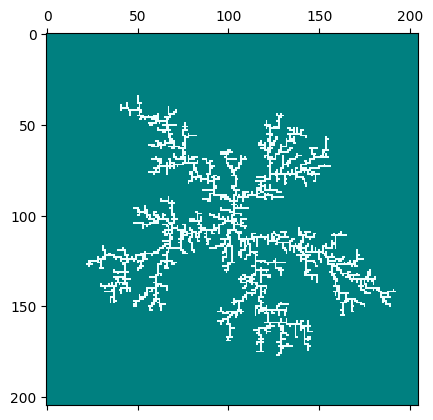

CPU times: user 3min 36s, sys: 1min 22s, total: 4min 59s
Wall time: 3min 43s


In [85]:
%%time
mass, matrix = DLAcluster(100, True)
plt.matshow(matrix, fignum=None, interpolation='nearest', cmap=colors.ListedColormap(['teal','azure', 'teal']))
plt.show()